=== PIPELINE: GridSearch(best_params) -> EarlyStop(best_epoch) -> RetrainFull -> Test ===
Seed=42, GRID_EPOCHS=500, MAX_EPOCHS_FOR_CURVE=500, PATIENCE=30
NOTE: alpha fixed to 0.0 (NOT tuned)


[MONK-1]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 16, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 500
   -> selected best_epoch: 488
   -> val_acc @ best_epoch:  100.00%
   -> val_loss @ best_epoch: 0.004125


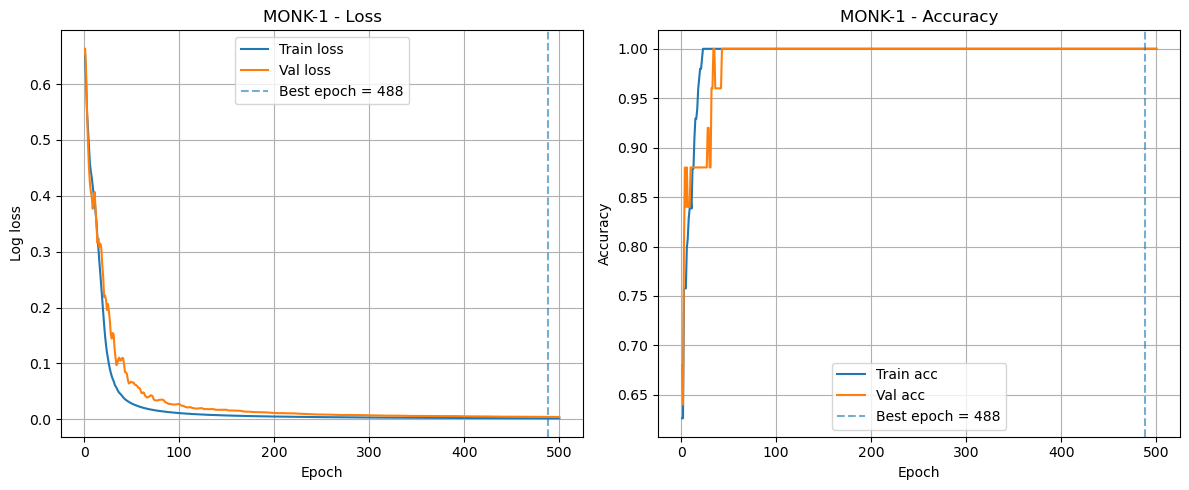

3) Retrain full data (100%) for best_epoch...
   -> train_acc (full): 100.00%
4) Test evaluation...
   -> test_acc: 100.00%
   -> test_logloss: 0.0022

[MONK-2]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 382
   -> selected best_epoch: 352
   -> val_acc @ best_epoch:  100.00%
   -> val_loss @ best_epoch: 0.001034


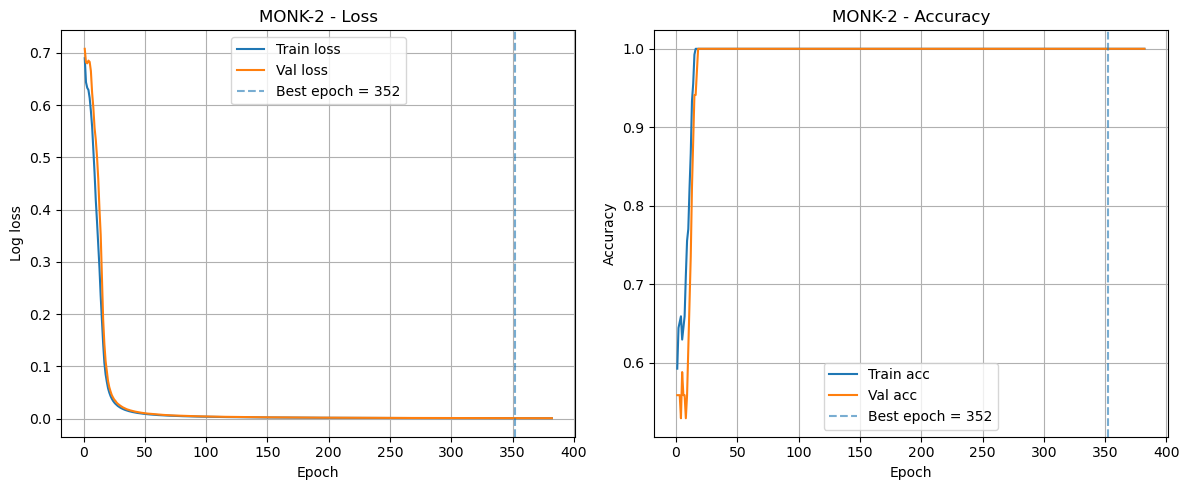

3) Retrain full data (100%) for best_epoch...
   -> train_acc (full): 100.00%
4) Test evaluation...
   -> test_acc: 100.00%
   -> test_logloss: 0.0008

[MONK-3]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 54
   -> selected best_epoch: 24
   -> val_acc @ best_epoch:  100.00%
   -> val_loss @ best_epoch: 0.068221


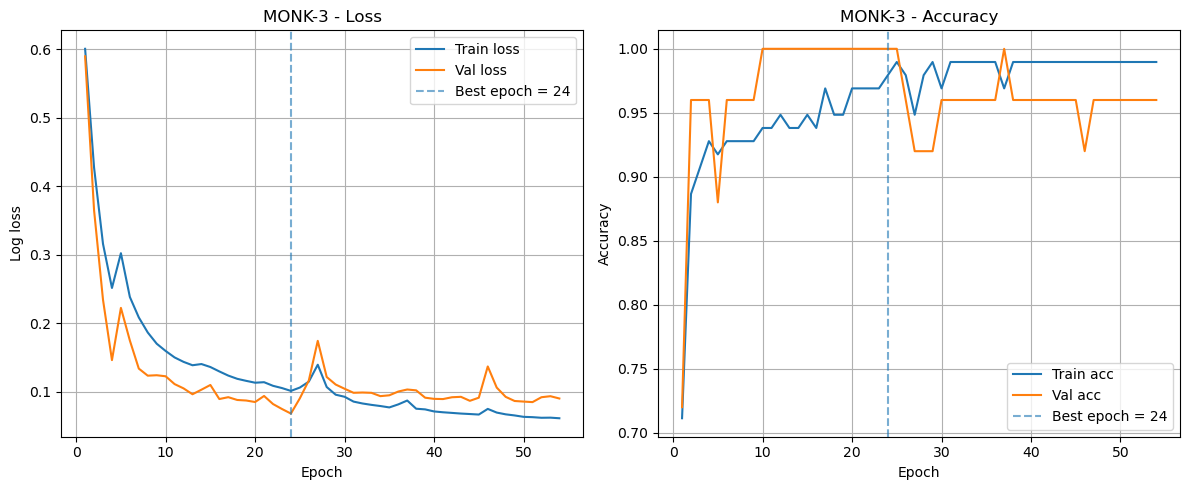

3) Retrain full data (100%) for best_epoch...
   -> train_acc (full): 97.54%
4) Test evaluation...
   -> test_acc: 96.53%
   -> test_logloss: 0.1099

SUMMARY
MONK-1: best_epoch=488 | train_acc=100.00% | test_acc=100.00% | test_ll=0.0022
MONK-2: best_epoch=352 | train_acc=100.00% | test_acc=100.00% | test_ll=0.0008
MONK-3: best_epoch= 24 | train_acc= 97.54% | test_acc= 96.53% | test_ll=0.1099


In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.base import clone

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# PART 0: SETUP
GLOBAL_SEED = 42

def set_reproducibility(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    return seed

set_reproducibility(GLOBAL_SEED)

# Global configs
GRID_EPOCHS = 500
MAX_EPOCHS_FOR_CURVE = 500
TOL = 1e-4
PATIENCE = 30

# Early-stop thresholds 
TOL_LOSS = 1e-4
TOL_ACC  = 1e-4

# IMPORTANT
FIXED_ALPHA = 0.0

# DATA LOADING
def load_monk_data_sklearn(monk_number):
    path_train = f"./dataset/monks-{monk_number}.train"
    path_test  = f"./dataset/monks-{monk_number}.test"

    if not os.path.exists(path_train):
        print(f"Error: Dataset not found at {path_train}")
        return None, None, None, None

    def one_hot(data):
        feature_counts = [3, 3, 2, 3, 4, 2]
        encoded = [np.eye(feature_counts[i])[data[:, i+1].astype(int) - 1] for i in range(6)]
        return np.concatenate(encoded, axis=1)

    def read_dataset(path):
        df = pd.read_csv(path, sep=' ', header=None, skipinitialspace=True).iloc[:, :7]
        X = one_hot(df.values)
        y = df.values[:, 0].astype(int)
        return X, y

    X_train, y_train = read_dataset(path_train)
    X_test,  y_test  = read_dataset(path_test)
    return X_train, y_train, X_test, y_test

def best_model_tie_break(cv_results):
    accuracies = cv_results['mean_test_accuracy']
    neg_log_losses = cv_results['mean_test_neg_log_loss']
    best_acc = np.max(accuracies)
    candidates = np.where(np.isclose(accuracies, best_acc))[0]
    return candidates[np.argmax(neg_log_losses[candidates])]

# LEARNING CURVE + EARLY STOP (HOLDOUT VAL)
def train_curve_earlystop(
    X_tr, y_tr, X_va, y_va,
    best_params,
    max_epochs=500,
    patience=30,
    tol_loss=1e-4,
    tol_acc=1e-4,
    seed=42
):

    model = MLPClassifier(
        solver="sgd",
        max_iter=1,             
        tol=0.0,                 
        n_iter_no_change=10**9,  
        shuffle=False,           
        random_state=seed,
        alpha=FIXED_ALPHA,      
        **best_params
    )

    classes = np.unique(np.concatenate([y_tr, y_va]))
    rng = np.random.RandomState(seed)

    hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = np.inf
    best_val_acc  = -np.inf
    best_epoch = 0
    wait = 0

    for ep in range(1, max_epochs + 1):
        Xs, ys = shuffle(X_tr, y_tr, random_state=rng)

        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

        # Metrics
        tr_prob = model.predict_proba(X_tr)
        va_prob = model.predict_proba(X_va)

        tr_pred = model.classes_[np.argmax(tr_prob, axis=1)]
        va_pred = model.classes_[np.argmax(va_prob, axis=1)]

        tr_loss = log_loss(y_tr, tr_prob, labels=model.classes_)
        va_loss = log_loss(y_va, va_prob, labels=model.classes_)
        tr_acc  = accuracy_score(y_tr, tr_pred)
        va_acc  = accuracy_score(y_va, va_pred)

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_acc"].append(va_acc)

        improved_loss = va_loss < (best_val_loss - tol_loss)
        improved_acc  = va_acc  > (best_val_acc  + tol_acc)

        if improved_loss or improved_acc:
            if improved_loss:
                best_val_loss = va_loss
            if improved_acc:
                best_val_acc = va_acc
            best_epoch = ep
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return hist, best_epoch

def plot_learning_curve(hist, best_epoch, title):
    e = hist["epoch"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(e, hist["train_loss"], label="Train loss")
    ax1.plot(e, hist["val_loss"], label="Val loss")
    if 1 <= best_epoch <= len(e):
        ax1.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best epoch = {best_epoch}")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log loss")
    ax1.set_title(f"{title} - Loss")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(e, hist["train_acc"], label="Train acc")
    ax2.plot(e, hist["val_acc"], label="Val acc")
    if 1 <= best_epoch <= len(e):
        ax2.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best epoch = {best_epoch}")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{title} - Accuracy")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# RETRAIN FULL DATA FOR EXACT EPOCHS
def retrain_full_for_epochs(X_all, y_all, best_params, epochs, seed=42):
    template = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,
        random_state=seed,
        alpha=FIXED_ALPHA,   
        **best_params
    )
    model = clone(template)

    classes = np.unique(y_all)
    rng = np.random.RandomState(seed)

    for ep in range(1, epochs + 1):
        Xs, ys = shuffle(X_all, y_all, random_state=rng)
        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

    return model

# MAIN: RUN ALL MONKS
if __name__ == "__main__":
    print("=== PIPELINE: GridSearch(best_params) -> EarlyStop(best_epoch) -> RetrainFull -> Test ===")
    print(f"Seed={GLOBAL_SEED}, GRID_EPOCHS={GRID_EPOCHS}, MAX_EPOCHS_FOR_CURVE={MAX_EPOCHS_FOR_CURVE}, PATIENCE={PATIENCE}")
    print(f"NOTE: alpha fixed to {FIXED_ALPHA} (NOT tuned)\n")

    results = []

    for m in [1, 2, 3]:
        X_all, y_all, X_test, y_test = load_monk_data_sklearn(m)
        if X_all is None:
            continue

        classes = np.unique(y_all)

        print("\n" + "="*70)
        print(f"[MONK-{m}]")
        print("="*70)

        # STEP 1: GridSearch best_params (no alpha)
        print("1) GridSearch: selecting best_params (alpha fixed)...")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_SEED)

        base_estimator = MLPClassifier(
            solver="sgd",
            max_iter=GRID_EPOCHS,
            early_stopping=True,
            validation_fraction=0.2,
            tol=TOL,
            n_iter_no_change=PATIENCE,
            random_state=GLOBAL_SEED,
            alpha=FIXED_ALPHA
        )

        param_grid = {
            "batch_size": [8, 16],
            "learning_rate_init": [0.01, 0.05, 0.005],
            "hidden_layer_sizes": [(2,), (3,), (4,)],
            "activation": ["relu", "tanh"],
            "momentum": [0.5, 0.7, 0.9]
        }

        grid = GridSearchCV(
            base_estimator,
            param_grid=param_grid,
            cv=cv,
            scoring={"accuracy": "accuracy", "neg_log_loss": "neg_log_loss"},
            refit=best_model_tie_break,
            n_jobs=-1
        )
        grid.fit(X_all, y_all)

        best_params = grid.best_params_
        print(f"   -> best_params: {best_params}")

        # STEP 2: Choose best_epoch by learning curve + early stop 
        print("2) Learning curve + early stop: selecting best_epoch (<=500)...")

        X_tr, X_va, y_tr, y_va = train_test_split(
            X_all, y_all, test_size=0.2, stratify=y_all, random_state=GLOBAL_SEED
        )

        hist, best_epoch = train_curve_earlystop(
            X_tr, y_tr, X_va, y_va,
            best_params=best_params,
            max_epochs=MAX_EPOCHS_FOR_CURVE,
            patience=PATIENCE,
            tol_loss=TOL_LOSS,
            tol_acc=TOL_ACC,
            seed=GLOBAL_SEED
        )

        idx = best_epoch - 1
        val_acc_at_best  = hist["val_acc"][idx]  if 0 <= idx < len(hist["val_acc"])  else 0.0
        val_loss_at_best = hist["val_loss"][idx] if 0 <= idx < len(hist["val_loss"]) else 0.0

        print(f"   -> curve ran to epoch: {hist['epoch'][-1]}")
        print(f"   -> selected best_epoch: {best_epoch}")
        print(f"   -> val_acc @ best_epoch:  {val_acc_at_best*100:.2f}%")
        print(f"   -> val_loss @ best_epoch: {val_loss_at_best:.6f}")

        plot_learning_curve(hist, best_epoch, title=f"MONK-{m}")

        # STEP 3: Retrain full 100% data for best_epoch
        print("3) Retrain full data (100%) for best_epoch...")
        final_model = retrain_full_for_epochs(X_all, y_all, best_params, epochs=best_epoch, seed=GLOBAL_SEED)

        train_acc_full = accuracy_score(y_all, final_model.predict(X_all))
        print(f"   -> train_acc (full): {train_acc_full*100:.2f}%")

        # -----------------------------
        # STEP 4: Test
        # -----------------------------
        print("4) Test evaluation...")
        test_pred = final_model.predict(X_test)
        test_prob = final_model.predict_proba(X_test)

        test_acc = accuracy_score(y_test, test_pred)
        test_ll  = log_loss(y_test, test_prob, labels=final_model.classes_)

        print(f"   -> test_acc: {test_acc*100:.2f}%")
        print(f"   -> test_logloss: {test_ll:.4f}")

        results.append((m, best_params, best_epoch, train_acc_full, test_acc, test_ll))

    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    for (m, bp, be, tracc, teacc, tell) in results:
        print(f"MONK-{m}: best_epoch={be:3d} | train_acc={tracc*100:6.2f}% | test_acc={teacc*100:6.2f}% | test_ll={tell:.4f}")


=== PIPELINE: GridSearch(best_params) -> EarlyStop(best_epoch) -> RetrainFull -> Test ===
Seed=42, GRID_EPOCHS=500, MAX_EPOCHS_FOR_CURVE=500, PATIENCE=30
NOTE: alpha fixed to 0.0 (NOT tuned)


[MONK-1]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 16, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 500
   -> selected best_epoch: 488
   -> train_acc @ best_epoch: 100.00%
   -> train_loss @ best_epoch: 0.001857
   -> val_acc   @ best_epoch: 100.00%
   -> val_loss  @ best_epoch: 0.004125


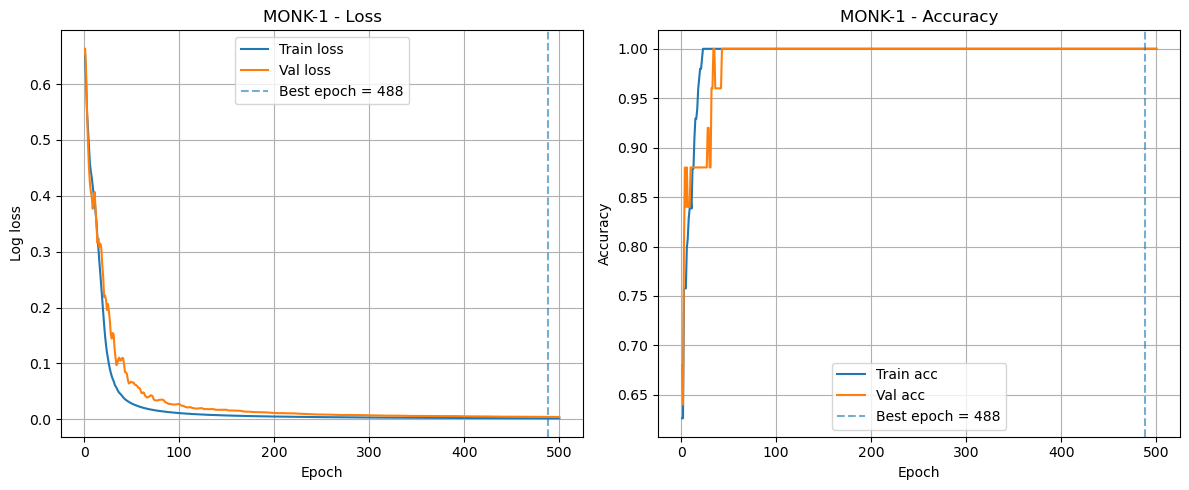

3) Retrain full data (100%) for best_epoch...
   -> train_acc  (full): 100.00%
   -> train_loss (full): 0.001606
4) Test evaluation...
   -> test_acc: 100.00%
   -> test_logloss: 0.0022

[MONK-2]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 382
   -> selected best_epoch: 352
   -> train_acc @ best_epoch: 100.00%
   -> train_loss @ best_epoch: 0.000916
   -> val_acc   @ best_epoch: 100.00%
   -> val_loss  @ best_epoch: 0.001034


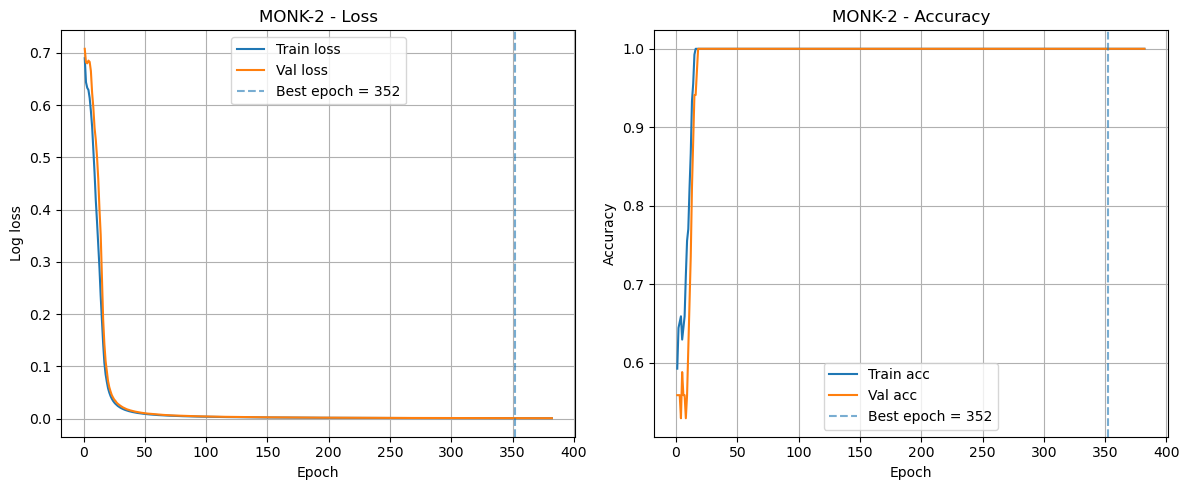

3) Retrain full data (100%) for best_epoch...
   -> train_acc  (full): 100.00%
   -> train_loss (full): 0.000726
4) Test evaluation...
   -> test_acc: 100.00%
   -> test_logloss: 0.0008

[MONK-3]
1) GridSearch: selecting best_params (alpha fixed)...
   -> best_params: {'activation': 'tanh', 'batch_size': 8, 'hidden_layer_sizes': (3,), 'learning_rate_init': 0.05, 'momentum': 0.9}
2) Learning curve + early stop: selecting best_epoch (<=500)...
   -> curve ran to epoch: 54
   -> selected best_epoch: 24
   -> train_acc @ best_epoch: 97.94%
   -> train_loss @ best_epoch: 0.101315
   -> val_acc   @ best_epoch: 100.00%
   -> val_loss  @ best_epoch: 0.068221


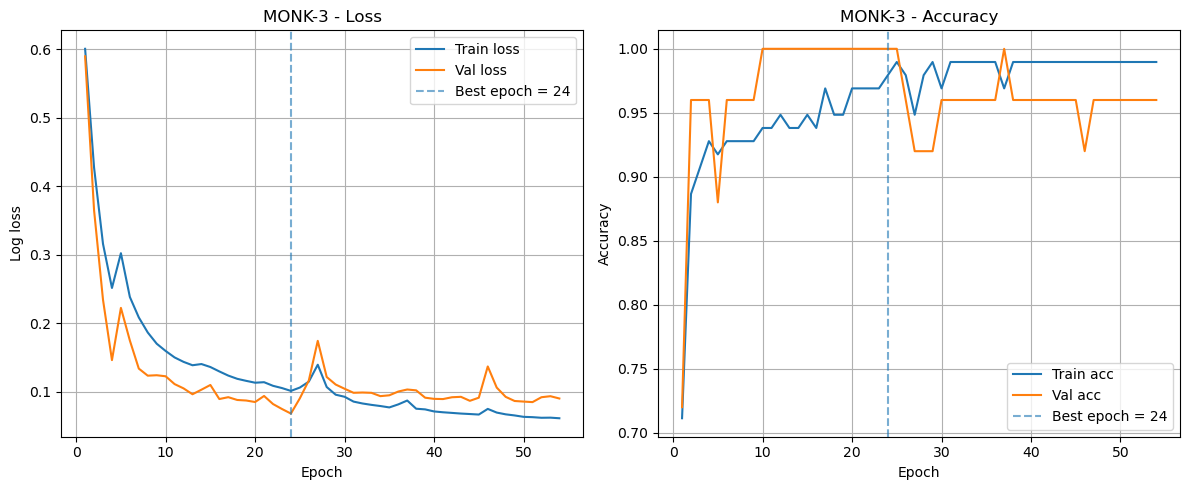

3) Retrain full data (100%) for best_epoch...
   -> train_acc  (full): 97.54%
   -> train_loss (full): 0.096805
4) Test evaluation...
   -> test_acc: 96.53%
   -> test_logloss: 0.1099

SUMMARY
MONK-1: best_epoch=488 | train_acc=100.00% | train_loss=0.0016 | test_acc=100.00% | test_ll=0.0022
MONK-2: best_epoch=352 | train_acc=100.00% | train_loss=0.0007 | test_acc=100.00% | test_ll=0.0008
MONK-3: best_epoch= 24 | train_acc= 97.54% | train_loss=0.0968 | test_acc= 96.53% | test_ll=0.1099


In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.base import clone

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# PART 0: SETUP
GLOBAL_SEED = 42

def set_reproducibility(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    return seed

set_reproducibility(GLOBAL_SEED)

# Global configs
GRID_EPOCHS = 500
MAX_EPOCHS_FOR_CURVE = 500
TOL = 1e-4
PATIENCE = 30

# Early-stop thresholds
TOL_LOSS = 1e-4
TOL_ACC  = 1e-4

# IMPORTANT
FIXED_ALPHA = 0.0

# DATA LOADING
def load_monk_data_sklearn(monk_number):
    path_train = f"./dataset/monks-{monk_number}.train"
    path_test  = f"./dataset/monks-{monk_number}.test"

    if not os.path.exists(path_train):
        print(f"Error: Dataset not found at {path_train}")
        return None, None, None, None

    def one_hot(data):
        feature_counts = [3, 3, 2, 3, 4, 2]
        encoded = [np.eye(feature_counts[i])[data[:, i+1].astype(int) - 1] for i in range(6)]
        return np.concatenate(encoded, axis=1)

    def read_dataset(path):
        df = pd.read_csv(path, sep=' ', header=None, skipinitialspace=True).iloc[:, :7]
        X = one_hot(df.values)
        y = df.values[:, 0].astype(int)
        return X, y

    X_train, y_train = read_dataset(path_train)
    X_test,  y_test  = read_dataset(path_test)
    return X_train, y_train, X_test, y_test

def best_model_tie_break(cv_results):
    accuracies = cv_results['mean_test_accuracy']
    neg_log_losses = cv_results['mean_test_neg_log_loss']
    best_acc = np.max(accuracies)
    candidates = np.where(np.isclose(accuracies, best_acc))[0]
    return candidates[np.argmax(neg_log_losses[candidates])]

# LEARNING CURVE + EARLY STOP (HOLDOUT VAL)
def train_curve_earlystop(
    X_tr, y_tr, X_va, y_va,
    best_params,
    max_epochs=500,
    patience=30,
    tol_loss=1e-4,
    tol_acc=1e-4,
    seed=42
):
    model = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,
        random_state=seed,
        alpha=FIXED_ALPHA,
        **best_params
    )

    classes = np.unique(np.concatenate([y_tr, y_va]))
    rng = np.random.RandomState(seed)

    hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = np.inf
    best_val_acc  = -np.inf
    best_epoch = 0
    wait = 0

    for ep in range(1, max_epochs + 1):
        Xs, ys = shuffle(X_tr, y_tr, random_state=rng)

        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

        # Metrics
        tr_prob = model.predict_proba(X_tr)
        va_prob = model.predict_proba(X_va)

        tr_pred = model.classes_[np.argmax(tr_prob, axis=1)]
        va_pred = model.classes_[np.argmax(va_prob, axis=1)]

        tr_loss = log_loss(y_tr, tr_prob, labels=model.classes_)
        va_loss = log_loss(y_va, va_prob, labels=model.classes_)
        tr_acc  = accuracy_score(y_tr, tr_pred)
        va_acc  = accuracy_score(y_va, va_pred)

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_acc"].append(va_acc)

        improved_loss = va_loss < (best_val_loss - tol_loss)
        improved_acc  = va_acc  > (best_val_acc  + tol_acc)

        if improved_loss or improved_acc:
            if improved_loss:
                best_val_loss = va_loss
            if improved_acc:
                best_val_acc = va_acc
            best_epoch = ep
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return hist, best_epoch

def plot_learning_curve(hist, best_epoch, title):
    e = hist["epoch"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(e, hist["train_loss"], label="Train loss")
    ax1.plot(e, hist["val_loss"], label="Val loss")
    if 1 <= best_epoch <= len(e):
        ax1.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best epoch = {best_epoch}")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log loss")
    ax1.set_title(f"{title} - Loss")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(e, hist["train_acc"], label="Train acc")
    ax2.plot(e, hist["val_acc"], label="Val acc")
    if 1 <= best_epoch <= len(e):
        ax2.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best epoch = {best_epoch}")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{title} - Accuracy")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# RETRAIN FULL DATA FOR EXACT EPOCHS
def retrain_full_for_epochs(X_all, y_all, best_params, epochs, seed=42):
    template = MLPClassifier(
        solver="sgd",
        max_iter=1,
        tol=0.0,
        n_iter_no_change=10**9,
        shuffle=False,
        random_state=seed,
        alpha=FIXED_ALPHA,
        **best_params
    )
    model = clone(template)

    classes = np.unique(y_all)
    rng = np.random.RandomState(seed)

    for ep in range(1, epochs + 1):
        Xs, ys = shuffle(X_all, y_all, random_state=rng)
        if ep == 1:
            model.partial_fit(Xs, ys, classes=classes)
        else:
            model.partial_fit(Xs, ys)

    return model


# MAIN: RUN ALL MONKS
if __name__ == "__main__":
    print("=== PIPELINE: GridSearch(best_params) -> EarlyStop(best_epoch) -> RetrainFull -> Test ===")
    print(f"Seed={GLOBAL_SEED}, GRID_EPOCHS={GRID_EPOCHS}, MAX_EPOCHS_FOR_CURVE={MAX_EPOCHS_FOR_CURVE}, PATIENCE={PATIENCE}")
    print(f"NOTE: alpha fixed to {FIXED_ALPHA} (NOT tuned)\n")

    results = []

    for m in [1, 2, 3]:
        X_all, y_all, X_test, y_test = load_monk_data_sklearn(m)
        if X_all is None:
            continue

        print("\n" + "="*70)
        print(f"[MONK-{m}]")
        print("="*70)

        # STEP 1: GridSearch best_params (no alpha)
        print("1) GridSearch: selecting best_params (alpha fixed)...")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_SEED)

        base_estimator = MLPClassifier(
            solver="sgd",
            max_iter=GRID_EPOCHS,
            early_stopping=True,
            validation_fraction=0.2,
            tol=TOL,
            n_iter_no_change=PATIENCE,
            random_state=GLOBAL_SEED,
            alpha=FIXED_ALPHA
        )

        param_grid = {
            "batch_size": [8, 16],
            "learning_rate_init": [0.01, 0.05, 0.005],
            "hidden_layer_sizes": [(2,), (3,), (4,)],
            "activation": ["relu", "tanh"],
            "momentum": [0.5, 0.7, 0.9]
        }

        grid = GridSearchCV(
            base_estimator,
            param_grid=param_grid,
            cv=cv,
            scoring={"accuracy": "accuracy", "neg_log_loss": "neg_log_loss"},
            refit=best_model_tie_break,
            n_jobs=-1
        )
        grid.fit(X_all, y_all)

        best_params = grid.best_params_
        print(f"   -> best_params: {best_params}")

        # STEP 2: Choose best_epoch by learning curve + early stop
        print("2) Learning curve + early stop: selecting best_epoch (<=500)...")

        X_tr, X_va, y_tr, y_va = train_test_split(
            X_all, y_all, test_size=0.2, stratify=y_all, random_state=GLOBAL_SEED
        )

        hist, best_epoch = train_curve_earlystop(
            X_tr, y_tr, X_va, y_va,
            best_params=best_params,
            max_epochs=MAX_EPOCHS_FOR_CURVE,
            patience=PATIENCE,
            tol_loss=TOL_LOSS,
            tol_acc=TOL_ACC,
            seed=GLOBAL_SEED
        )

        idx = best_epoch - 1
        val_acc_at_best  = hist["val_acc"][idx]  if 0 <= idx < len(hist["val_acc"])  else 0.0
        val_loss_at_best = hist["val_loss"][idx] if 0 <= idx < len(hist["val_loss"]) else 0.0

        # ADDED: also report TRAIN loss/acc at best_epoch from the curve
        tr_acc_at_best  = hist["train_acc"][idx]  if 0 <= idx < len(hist["train_acc"])  else 0.0
        tr_loss_at_best = hist["train_loss"][idx] if 0 <= idx < len(hist["train_loss"]) else 0.0

        print(f"   -> curve ran to epoch: {hist['epoch'][-1]}")
        print(f"   -> selected best_epoch: {best_epoch}")
        print(f"   -> train_acc @ best_epoch: {tr_acc_at_best*100:.2f}%")        # ADDED
        print(f"   -> train_loss @ best_epoch: {tr_loss_at_best:.6f}")          # ADDED
        print(f"   -> val_acc   @ best_epoch: {val_acc_at_best*100:.2f}%")
        print(f"   -> val_loss  @ best_epoch: {val_loss_at_best:.6f}")

        plot_learning_curve(hist, best_epoch, title=f"MONK-{m}")

        # STEP 3: Retrain full 100% data for best_epoch
        print("3) Retrain full data (100%) for best_epoch...")
        final_model = retrain_full_for_epochs(X_all, y_all, best_params, epochs=best_epoch, seed=GLOBAL_SEED)

        # Train metrics on FULL data after retraining
        train_pred_full = final_model.predict(X_all)
        train_prob_full = final_model.predict_proba(X_all)

        train_acc_full = accuracy_score(y_all, train_pred_full)
        train_ll_full  = log_loss(y_all, train_prob_full, labels=final_model.classes_)  # ADDED (train loss)

        print(f"   -> train_acc  (full): {train_acc_full*100:.2f}%")
        print(f"   -> train_loss (full): {train_ll_full:.6f}")  # ADDED

        # STEP 4: Test
        print("4) Test evaluation...")
        test_pred = final_model.predict(X_test)
        test_prob = final_model.predict_proba(X_test)

        test_acc = accuracy_score(y_test, test_pred)
        test_ll  = log_loss(y_test, test_prob, labels=final_model.classes_)

        print(f"   -> test_acc: {test_acc*100:.2f}%")
        print(f"   -> test_logloss: {test_ll:.4f}")

        # ADDED: store train loss in results
        results.append((m, best_params, best_epoch, train_acc_full, train_ll_full, test_acc, test_ll))

    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    for (m, bp, be, tracc, trll, teacc, tell) in results:
        print(
            f"MONK-{m}: best_epoch={be:3d} | "
            f"train_acc={tracc*100:6.2f}% | train_loss={trll:.4f} | "
            f"test_acc={teacc*100:6.2f}% | test_ll={tell:.4f}"
        )
